In [ ]:
just_checking_integrity=False
rows=3000
test_rows=1000

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
import datetime
from itertools import compress
from math import sin, cos
import ast

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

## Custom metric

In [ ]:
def mrr_top_at(at=100):
    @tf.function
    def mrr_top(y_true,y_pred):
        top_k=tf.math.top_k(y_pred,k=at)
        rr=top_k.indices
        #print(rr)
        idx=tf.range(start=1,limit=at+1,delta=1)
        y_true=tf.reshape(y_true,[-1,1])
        #print(y_true)
        #y_true=tf.broadcast_to(y_true,test.shape)
        y_true=tf.cast(y_true,tf.int32)
        ranking=tf.where(tf.math.equal(rr,y_true),idx,0)
        #print(ranking)
        ranking=tf.reduce_sum(ranking,axis=-1)
        ranking=tf.where(ranking>0,1/ranking,0)
        #print(ranking)
        ranking=tf.reduce_mean(ranking)
        return ranking
    return mrr_top

## Custom layers

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(
        self,
        maxlen,
        vocab_size,
        embed_dim,
        item_embedding_trainable=True,
        embedding_weights=None
        ):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            trainable=item_embedding_trainable,
            weights=embedding_weights
            )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=maxlen-1, limit=0, delta=-1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
class PositionEmbedding(layers.Layer):
    def __init__(
        self,
        maxlen,
        embed_dim,
        ):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return positions

In [ ]:
class RBFLayer(layers.Layer):
    def __init__(self, weights, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        # shape=(embedding_dimension, num_units)
        self.embedding_weights = tf.transpose(weights)
        self.gamma = gamma

    def call(self, inputs):
        l2 = tf.math.reduce_sum(
            tf.math.squared_difference(
                x=tf.expand_dims(inputs, axis=-1),
                y=self.embedding_weights
                ),
            axis=1
            )
        res = tf.math.exp(-self.gamma * l2)
        return res / tf.reduce_sum(res, axis=1, keepdims=True)

# Prepare dataset

In [ ]:
candidate_items = pd.read_csv('./drive/MyDrive/Recommendation_system/dataset/processed_data/candidate_items_mapped.csv')
candidate_items.head()

,item_id
0,1
1,2
2,3
3,4
4,5


In [ ]:
embedding_weights = np.load(
    './drive/MyDrive/Recommendation_system/dataset/processed_data/compressed_features.npy'
    )
import os
import scipy.sparse as sps
def get_ICM(files_directory="./drive/MyDrive/Recommendation_system/dataset/processed_data"):
    df_icm = pd.read_csv(filepath_or_buffer=os.path.join(files_directory, 'simplified_features_and_categories_30.csv'), sep=',', header=0)

    item_id_list = df_icm['item_id'].values
    feat_id_list = df_icm['feature_idx'].values
    rating_id_list = np.ones_like(feat_id_list)
    ICM_matrix = sps.csr_matrix((rating_id_list, (item_id_list, feat_id_list)))
    return ICM_matrix

ICM=get_ICM()
embedding_weights.shape

(23692, 64)

In [ ]:
result =  pd.read_csv("./drive/MyDrive/Recommendation_system/dataset/processed_data/macro_feats_NN.csv",parse_dates=["date_session_starting"],
     infer_datetime_format=True)



result["item_id"]=result["item_id"].map(ast.literal_eval)
result["timedelta"]=result["timedelta"].map(ast.literal_eval)

def is_reseen(x):
    #print(x)
    seen={}
    res=[]
    for item in x:
        if item in seen:
            res.append(seen[item])
            seen[item]+=1
        else:
            res.append(0)
            seen[item]=1
    return res

def percentage_seen(x):
    size=len(x)
    return [(i+1)/size for i in range(size)]

In [ ]:
x_reseen = tf.keras.preprocessing.sequence.pad_sequences(
    result['item_id'].progress_apply(is_reseen),
    padding='post',
    maxlen=100,
    dtype="int16"
)
x_percentage_seen = tf.keras.preprocessing.sequence.pad_sequences(
    result['item_id'].progress_apply(percentage_seen),
    padding='post',
    maxlen=100,
    dtype='float16',
)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
def similarity_with_preceding(x):
    if len(x)==1:
        return np.array([0])
    feats=embedding_weights[x]
    #normalize
    feats=np.divide(feats,np.linalg.norm(feats,axis=1).reshape((-1,1)))
    feats_copy=feats.copy()
    feats_copy=np.roll(feats_copy,1,axis=0)
    feats_copy[0,:]=0
    prod=np.multiply(feats,feats_copy).sum(axis=1)
    return prod



def similarity_feats_with_preceding(x):
    if len(x)==1:
        return np.array([0])
    feats=ICM[x].toarray()
    #normalize
    feats=np.divide(feats,np.linalg.norm(feats,axis=1).reshape((-1,1)))
    feats_copy=feats.copy()
    feats_copy=np.roll(feats_copy,1,axis=0)
    feats_copy[0,:]=0
    prod=np.multiply(feats,feats_copy).sum(axis=1)
    return prod

In [ ]:
x_simils = tf.keras.preprocessing.sequence.pad_sequences(
    result['item_id'].progress_apply(similarity_with_preceding
    ),
    padding='post',
    maxlen=100,
    dtype='float16',
)
x_simils_feats = tf.keras.preprocessing.sequence.pad_sequences(
    result['item_id'].progress_apply(similarity_feats_with_preceding
    ),
    padding='post',
    maxlen=100,
    dtype='float16',
)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
static_features_names = [
                   'date_hour_sin',
                   'date_hour_cos',
                   'date_day_sin',
                   'date_day_cos',
                   'date_month_sin',
                   'date_month_cos',
                   'date_hour_sin_ending',
                   'date_hour_cos_ending',
                   'date_day_sin_ending',
                   'date_day_cos_ending',
                   'date_month_sin_ending',
                   'date_month_cos_ending',
                   'date_year_2020',
                   'length_of_session_seconds',
                   'avg_time_spent_per_item_seconds',
                   'variance_time_spent_per_item_seconds',
                   'n_seen_items',
                   'n_unique_items',
                   'user_went_afk',
                   'is_weekend',
                   'is_hot_hour',
                   'is_night',
                   'is_christmas_time',
                   'is_black_friday',
                   'session_similarity',
                   'session_similarity_uniques',
                   'session_similarity_feats',
                   'session_similarity_feats_uniques'
]
for col in ['length_of_session_seconds','avg_time_spent_per_item_seconds','variance_time_spent_per_item_seconds']:
    result[col]=np.log10(result[col]+1)
for col in ['n_seen_items','n_unique_items']:
    result[col]=result[col]/100

item_related_features = [
                         'timedelta'
]

In [ ]:
if just_checking_integrity:
    train_purchases = pd.read_csv(
    './drive/MyDrive/Recommendation_system/dataset/processed_data/train_purchases_mapped.csv',
    usecols = ['session_id', 'item_id'],
    nrows=len(result)
    )
else:
    train_purchases = pd.read_csv(
    './drive/MyDrive/Recommendation_system/dataset/processed_data/train_purchases_mapped.csv',
    usecols = ['session_id', 'item_id'],
    )
train_purchases.head()

,session_id,item_id
0,663204,12492
1,85375,3299
2,374472,17411
3,526578,11229
4,66630,11568


In [ ]:
train_purchases.sort_values(by="session_id",inplace=True)

In [ ]:
x_ids = tf.keras.preprocessing.sequence.pad_sequences(
    result['item_id'],
    padding='post',
    maxlen=100,
)

In [ ]:
for item_related_feature in item_related_features:
  print('Padding {}'.format(item_related_feature))
  x_item_related = tf.keras.preprocessing.sequence.pad_sequences(
      result[item_related_feature],
      dtype='float16',
      maxlen=100,
      padding='post'
    )

Padding timedelta


In [ ]:
if len(item_related_features) == 1:
  x_item_related = np.expand_dims(x_item_related, axis=-1)

In [ ]:
y = train_purchases['item_id'].to_numpy()

In [ ]:
y_features = embedding_weights[y]

In [ ]:
last_month_start = datetime.datetime.strptime("01/05/21 00:00:00", '%d/%m/%y %H:%M:%S')
static_features=result[static_features_names].to_numpy()

indexer = result["date_session_starting"]>=last_month_start

x_session_ids_last_month=result["session_id"][indexer]
x_ids_last_month=x_ids[indexer,:]
x_reseen_last_month=x_reseen[indexer,:]
x_simils_last_month=x_simils[indexer,:]
x_simils_feats_last_month=x_simils_feats[indexer,:]
x_percentage_seen_last_month=x_percentage_seen[indexer,:]
static_features_last_month=static_features[indexer,:]
x_item_related_last_month=x_item_related[indexer,:]
y_last_month=y[indexer]
y_features_last_month=y_features[indexer,:]



indexer_train = result["date_session_starting"]<last_month_start


x_ids=x_ids[indexer_train,:]
x_reseen=x_reseen[indexer_train,:]
x_simils=x_simils[indexer_train,:]
x_simils_feats=x_simils_feats[indexer_train,:]
x_percentage_seen=x_percentage_seen[indexer_train,:]
static_features=static_features[indexer_train,:]
x_item_related=x_item_related[indexer_train,:]
y=y[indexer_train]
y_features=y_features[indexer_train,:]

In [ ]:
x_ids_train, x_ids_test,\
x_reseen_train, x_reseen_test,\
x_simils_train,x_simils_test,\
x_simils_feats_train,x_simils_feats_test,\
x_percentage_seen_train,x_percentage_seen_test,\
x_static_train, x_static_test, \
x_item_related_train, x_item_related_test, \
y_train, y_test, \
y_features_train, y_features_test = train_test_split(
    x_ids,
    x_reseen,
    x_simils,
    x_simils_feats,
    x_percentage_seen,
    static_features,
    x_item_related,
    y,
    y_features,
    test_size=0.2,
    random_state=1234
    )

In [ ]:
shape=y_features_train.shape[1]

In [ ]:
del x_ids,x_reseen,x_simils,x_simils_feats,x_percentage_seen,result,x_item_related,y,y_features
import gc
gc.collect()

18

# Build Dataset

In [ ]:
if just_checking_integrity:
    train_set_complete = tf.data.Dataset.from_tensor_slices(
        ((x_ids_train, x_reseen_train/100,x_percentage_seen_train,x_simils_train,x_simils_feats_train, x_item_related_train, x_static_train), (y_train, y_features_train))
        ).batch(128,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).shuffle(4, reshuffle_each_iteration=True)
else:
    train_set_complete = tf.data.Dataset.from_tensor_slices(
        ((x_ids_train, x_reseen_train/100,x_percentage_seen_train,x_simils_train,x_simils_feats_train, x_item_related_train, x_static_train), (y_train, y_features_train))
        ).batch(512,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).shuffle(1435, reshuffle_each_iteration=True)
test_set_complete = tf.data.Dataset.from_tensor_slices(
    ((x_ids_test, x_reseen_test/100, x_percentage_seen_test,x_simils_test,x_simils_feats_test, x_item_related_test, x_static_test), (y_test, y_features_test))
    ).batch(128)
gc.collect()

18

In [ ]:
train_set_complete.element_spec

((TensorSpec(shape=(None, 100), dtype=tf.int32, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float64, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100, 1), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 28), dtype=tf.float64, name=None)),
 (TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  TensorSpec(shape=(None, 64), dtype=tf.float32, name=None)))

# Contex aware GRU NET

In [ ]:
embed_dim = 64  # Embedding size for each token
maxlen = 100
num_static = len(static_features_names)
num_item_related = len(item_related_features)
vocabulary_size = 23692 #max(train_purchases['item_id']) # Size of the vocabulary
rnn_width = 512 - 128 - num_static - num_item_related - 4
mlp_width = 512
mlp_depth = 2

###### INPUT #####
id_inputs = layers.Input(shape=(maxlen,), name='ids')
item_related_inputs = layers.Input(shape=(maxlen, num_item_related), name='item_related_features')
x_reseen_inputs = layers.Input(shape=(maxlen, 1), name='x_reseen_featurs')
x_percentage_seen_inputs = layers.Input(shape=(maxlen, 1), name='x_percentage_seen')
x_simils_inputs = layers.Input(shape=(maxlen, 1), name='x_similarities_embeddings')
x_simils_feats_inputs = layers.Input(shape=(maxlen, 1), name='x_similarities_ICM')
static_inputs = layers.Input(shape=(num_static,), name='static_features')

##### MODEL DEFINITION #####

learned_embedding = layers.Embedding(
    input_dim=vocabulary_size,
    output_dim=embed_dim,
    mask_zero=True,
    name='learned_embedding'
    )(id_inputs)

feature_embedding = layers.Embedding(
    input_dim=embedding_weights.shape[0],
    output_dim=embedding_weights.shape[1],
    mask_zero=True,
    trainable=False,
    weights=[embedding_weights],
    name='feature_embedding'
    )(id_inputs)

embedding = layers.Concatenate(
    name='embedding'
)([learned_embedding, feature_embedding])

x_pre = embedding

masked_item_related_inputs = item_related_inputs[:, :tf.shape(id_inputs)[-1], :]

x_pre = layers.Concatenate()([x_pre, masked_item_related_inputs, x_reseen_inputs,x_percentage_seen_inputs,x_simils_inputs,x_simils_feats_inputs])

x_post = layers.GRU(
    units=rnn_width,
    return_sequences=False,
    dropout=0.1,
    #unroll=True,
    name='recurrrent1'
)(x_pre)

x_pre = layers.GlobalAveragePooling1D()(x_pre)
x_pre = layers.Concatenate()([x_post, x_pre, static_inputs])

for layer in range(mlp_depth):
  x_post = layers.BatchNormalization()(x_pre)
  x_post = layers.Dropout(0.2)(x_post)
  x_post = layers.Dense(units=mlp_width, activation='gelu')(x_post)
  x_pre = layers.Add()([x_pre, x_post])

##### PREDICTION DEFINITION #####

outputs = layers.Dense(19021, activation='softmax', name='y')(x_pre)
secondary_outputs = layers.Dense(
    units=shape,
    activation='tanh',
    name='y_features'
    )(x_pre)

model_for_training= tf.keras.Model(
    inputs=[id_inputs, x_reseen_inputs, x_percentage_seen_inputs,x_simils_inputs,x_simils_feats_inputs,item_related_inputs, static_inputs],
    outputs=[outputs, secondary_outputs],
    name="encodermodel_training"
    )


model_for_training.compile(
    optimizer="adamax",
    loss=[
          lambda y_true, y_pred : tf.keras.losses.categorical_crossentropy(
              tf.squeeze(tf.one_hot(tf.cast(y_true, dtype=tf.int32), 19020+1, axis=-1)),
              y_pred,
              label_smoothing=0.7
              ),
          'mse'
    ],
    loss_weights=[1, 1],
    metrics=[
             [
              mrr_top_at(at=100)
             ],
             []
             ]
    )


# Plot

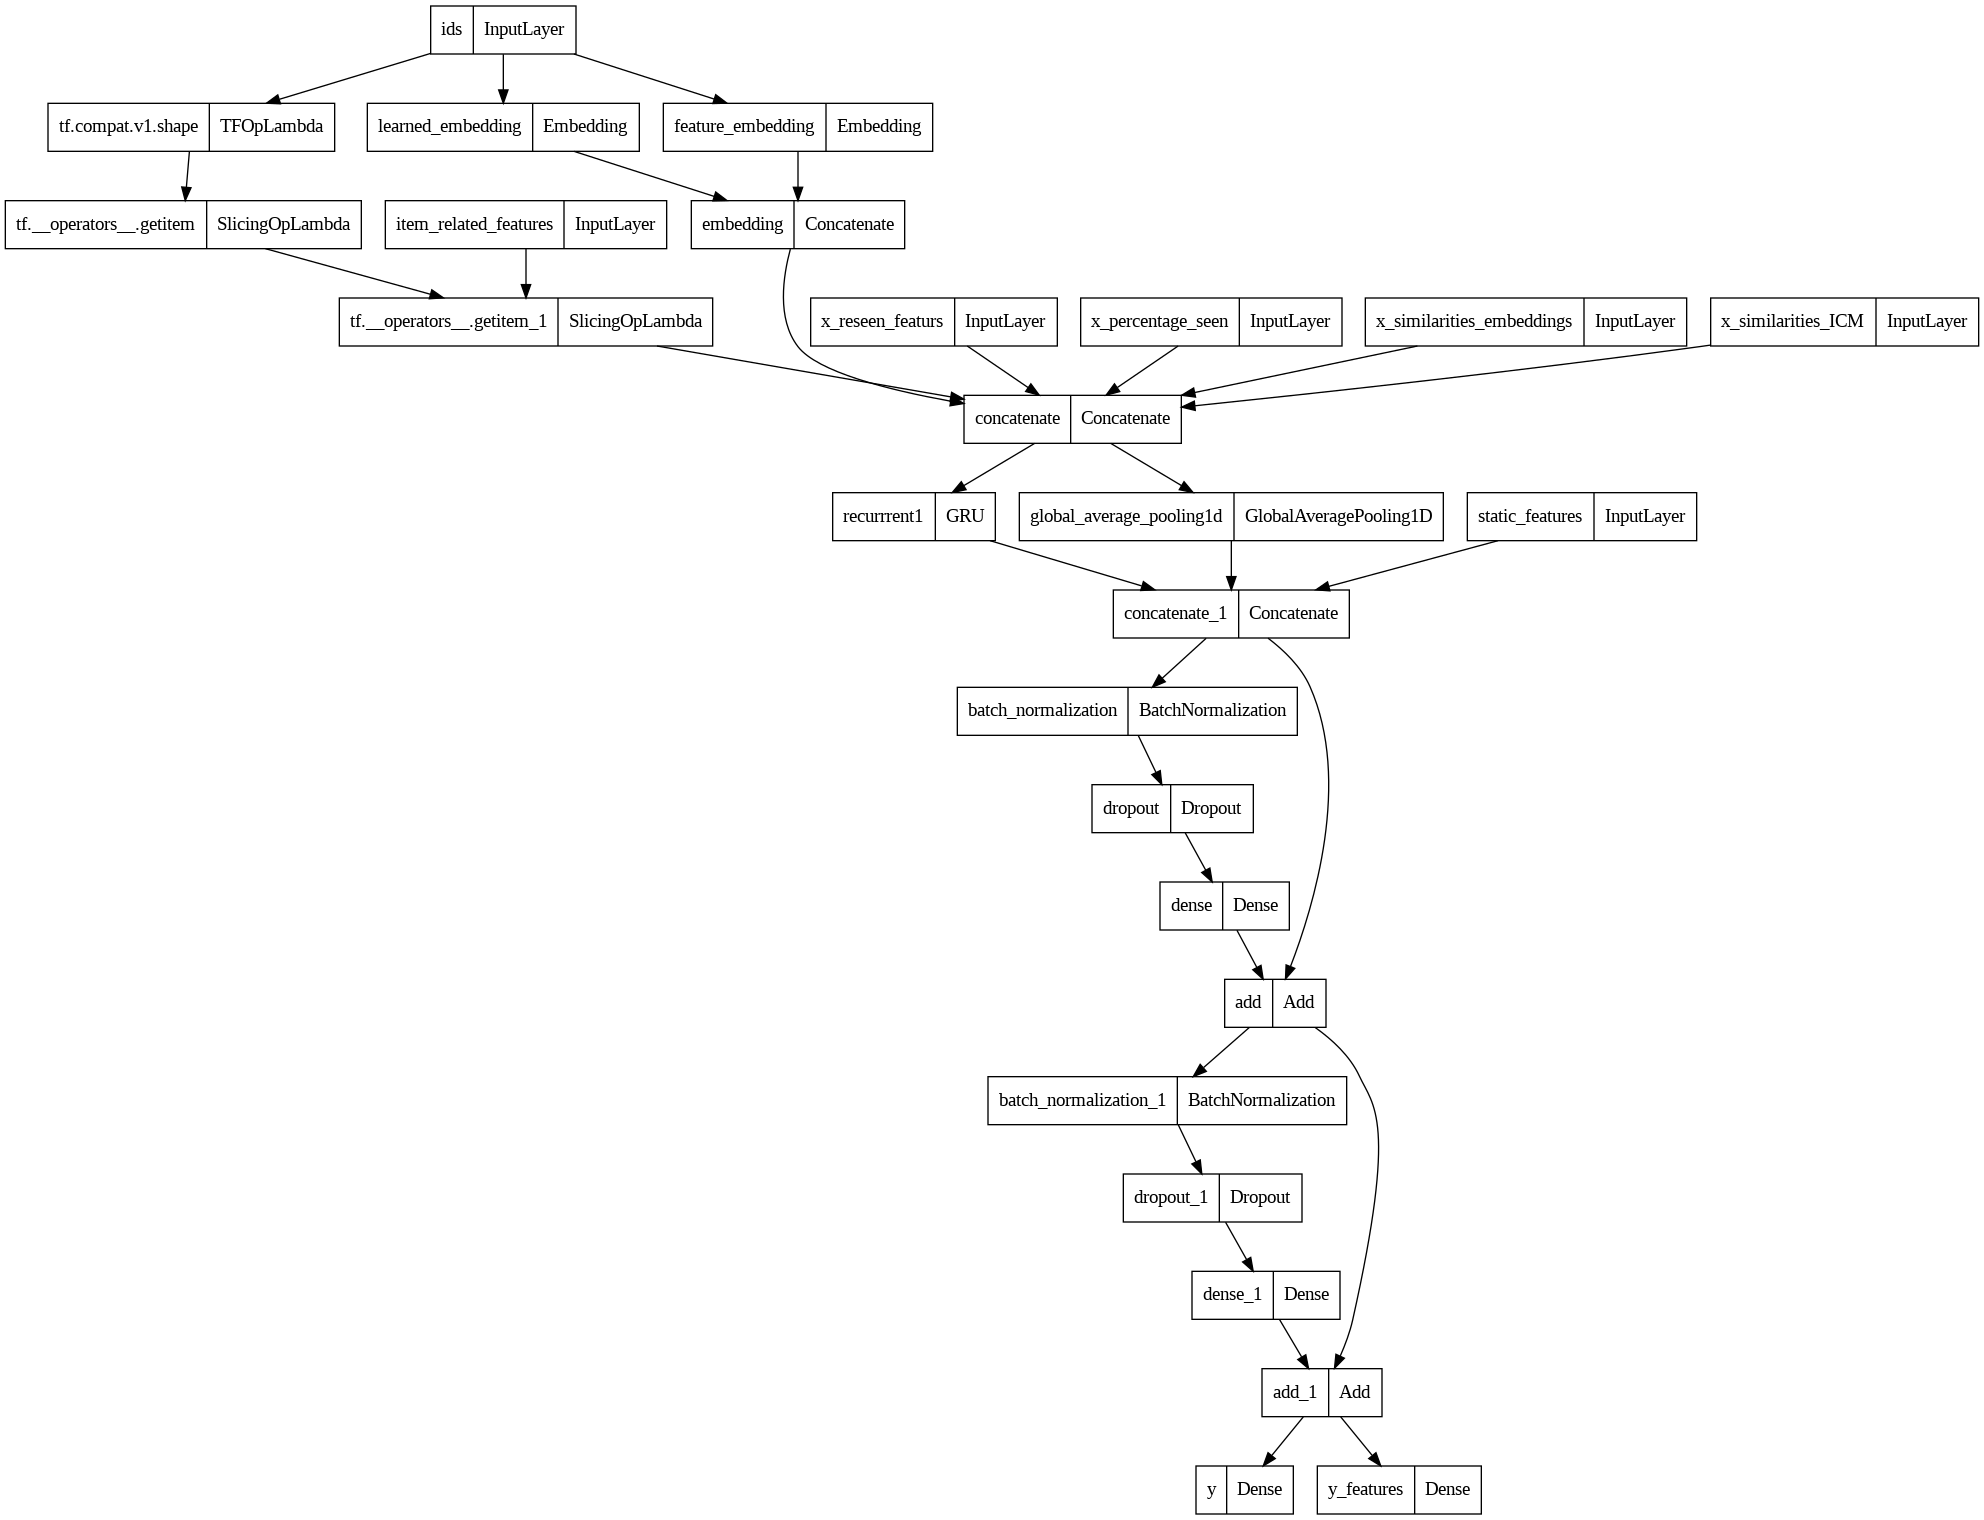

In [ ]:
tf.keras.utils.plot_model(model_for_training,to_file="./model.png",expand_nested=True)

# Training

In [ ]:
gc.collect()
if just_checking_integrity:
    n_epochs=2
else:
    n_epochs=100
monitor='val_y_mrr_top'
model_for_training.fit(
    train_set_complete,
    validation_data=test_set_complete,
    epochs=n_epochs,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(
                  monitor=monitor,
                  mode='max',
                  patience=1,
                  min_delta=0.0001,
                  restore_best_weights=True,
              ),
         ]
    )


Epoch 1/100
1435/1435 [==============================] - 138s 84ms/step - loss: 9.5270 - y_loss: 9.4820 - y_features_loss: 0.0450 - y_mrr_top: 0.0773 - val_loss: 9.3409 - val_y_loss: 9.3296 - val_y_features_loss: 0.0113 - val_y_mrr_top: 0.1195
Epoch 2/100
1435/1435 [==============================] - 73s 45ms/step - loss: 9.2903 - y_loss: 9.2795 - y_features_loss: 0.0108 - y_mrr_top: 0.1366 - val_loss: 9.2586 - val_y_loss: 9.2481 - val_y_features_loss: 0.0104 - val_y_mrr_top: 0.1497
Epoch 3/100
1435/1435 [==============================] - 73s 46ms/step - loss: 9.2098 - y_loss: 9.1992 - y_features_loss: 0.0105 - y_mrr_top: 0.1635 - val_loss: 9.2210 - val_y_loss: 9.2107 - val_y_features_loss: 0.0104 - val_y_mrr_top: 0.1655
Epoch 4/100
1435/1435 [==============================] - 73s 46ms/step - loss: 9.1573 - y_loss: 9.1467 - y_features_loss: 0.0105 - y_mrr_top: 0.1822 - val_loss: 9.2022 - val_y_loss: 9.1918 - val_y_features_loss: 0.0104 - val_y_mrr_top: 0.1747
Epoch 5/100
1435/1435 [====

# Prepare candidates last month

In [ ]:
submission_set = tf.data.Dataset.from_tensor_slices(
    (
        x_session_ids_last_month,
     (
        x_ids_last_month,
        x_reseen_last_month/100,
        x_percentage_seen_last_month,
        x_simils_last_month,
        x_simils_feats_last_month,
        x_item_related_last_month,
        static_features_last_month
     )
    )
).batch(128)
submission_set.element_spec

(TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 (TensorSpec(shape=(None, 100), dtype=tf.int32, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float64, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 100, 1), dtype=tf.float16, name=None),
  TensorSpec(shape=(None, 28), dtype=tf.float64, name=None)))

In [ ]:
submission_df = pd.DataFrame(
    {
        'session_id':[],
        'code':[],
        'score':[],
        'rank':[]
    }
)

submission_df.head()

,session_id,code,score,rank


In [ ]:
candidates=np.unique(y_last_month) # this is for the test month

In [ ]:
candidates

array([    1,     2,     3, ..., 18923, 18926, 18945])

In [ ]:
for session_ids, sessions in submission_set:
    predicted_scores=model_for_training(sessions)[0].numpy()
    mask = np.ones(predicted_scores.shape[1], dtype=bool)
    mask[candidates] = False
    predicted_scores[...,mask]=-np.inf
    predicted_scores=tf.convert_to_tensor(predicted_scores)
    preds=tf.math.top_k(predicted_scores, k=100)
    scores=preds.values.numpy()
    code = preds.indices.numpy()
    prediction = pd.DataFrame(
        {
            'session_id':session_ids,
            'code':[tuple(v) for v in code],
            'score':[tuple(v) for v in scores],
            'rank':[tuple([rank for rank in range(1, 101)]) for id in session_ids]
        }
        )

    submission_df = pd.concat([submission_df, prediction])

submission_df.head()

,session_id,code,score,rank
0,918382.0,"(2785, 3844, 2865, 1813, 513, 3731, 1047, 1458...","(0.022902498, 0.017147847, 0.016835079, 0.0144...","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,918383.0,"(4741, 3282, 4503, 232, 2779, 3593, 786, 781, ...","(0.02504064, 0.014390639, 0.0139800925, 0.0115...","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,918384.0,"(3194, 3004, 294, 2799, 1977, 2577, 99, 2629, ...","(0.04775348, 0.030970503, 0.014160282, 0.01271...","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,918385.0,"(3155, 3362, 2037, 1609, 2780, 2159, 4184, 438...","(0.036779925, 0.027683446, 0.014741135, 0.0132...","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,918386.0,"(2161, 3416, 2008, 302, 4760, 3899, 3297, 4942...","(0.003310331, 0.0031643205, 0.002813286, 0.002...","(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [ ]:
submission_df.to_csv(
    './drive/MyDrive/Recommendation_system/dataset/candidates/NN/GRU/train/candidates.csv',
    index=False
    )